In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

import statsmodels.api as sm
import patsy
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

In [44]:
with open('UN_data_transform.pickle', 'rb') as file:
    UN = pickle.load(file)
    file.close()
UN.head()

,Country,Year,exp_imp,gva_servc,labor_part,food_prod,life_exp,pop_gain,urban,log_gdp,log_pop_density,log_pop,log_gender_ratio,log_energy_prod,log_energy_supp,sqrt_internet,log_edu_prim,sqrt_gva_ag,sqrt_gva_indst,sqrt_unemp,log_tourism,log_health,sqrt_parliam_women,log_cpi,log_mort_child,log_mort_mother,log_num_child,log_pop_migrants,log_pop_unhcr,log_ghg_emissions
0,Afghanistan,2005,-237.675,38.794,64.3,106.6,56.9,4.4,22.7,5.576,3.648,3.222,4.675,0.155,0.000,1.095,5.149,5.937,5.095,2.915,1.593,2.297,5.244,4.264,4.494,6.711,1.974,-1.204,8.759,-0.274
1,Afghanistan,2010,-165.486,49.843,63.3,116.2,60.0,2.8,23.7,6.324,3.786,3.360,4.661,0.515,1.609,2.000,5.211,5.367,4.620,2.793,1.678,2.148,5.225,4.605,4.340,6.370,1.856,-0.916,10.637,0.058
2,Afghanistan,2015,-211.944,54.664,65.3,119.6,62.3,3.2,24.8,6.415,3.945,3.519,4.667,0.707,1.386,2.881,5.235,4.760,4.762,2.983,1.040,2.312,5.263,4.884,4.228,5.981,1.668,0.405,10.648,0.336
3,Albania,2005,-635.065,49.787,57.9,98.0,74.8,-0.3,46.7,7.869,4.722,1.125,4.611,2.762,3.367,2.449,4.347,4.641,5.355,4.183,5.656,1.847,2.530,4.462,3.049,3.401,0.642,0.742,3.397,0.986
4,Albania,2010,-1038.435,50.651,54.3,119.1,75.6,-0.9,52.2,8.308,4.676,1.078,4.612,3.166,3.434,6.708,4.337,4.545,5.356,3.768,6.405,1.611,4.050,4.605,2.821,3.401,0.470,0.588,3.517,1.040


In [45]:
UN.Country.nunique()

182

In [46]:
#Train-test split with 2015 data as test
train = UN[(UN.Year == 2005) | (UN.Year == 2010)]
test = UN[UN.Year == 2015]
print(train.shape, test.shape)

(362, 30) (182, 30)


In [47]:
#Make design matrix with all features as predictors except log_gdp
y, X = patsy.dmatrices('log_gdp ~ exp_imp + gva_servc + labor_part + \
                       food_prod + life_exp + pop_gain + urban + log_pop_density + \
                       log_pop + log_gender_ratio + log_energy_prod + log_energy_supp +\
                       sqrt_internet + log_edu_prim + sqrt_gva_ag + sqrt_gva_indst + \
                       sqrt_unemp + log_tourism + log_health + sqrt_parliam_women + \
                       log_cpi + log_mort_child + log_mort_mother + log_num_child + \
                       log_pop_migrants + log_pop_unhcr + log_ghg_emissions', 
                       data = UN, return_type = "dataframe")

#Split predictor and response frames according to train-test grouping
X_train, X_test = X[X.index.isin(train.index)], X[X.index.isin(test.index)]
y_train, y_test = y[y.index.isin(train.index)], y[y.index.isin(test.index)]

#Fit base linear regression model with statsmodels
lm_base = sm.OLS(y_train, X_train)
fit_base = lm_base.fit()
fit_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_gdp   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     254.3
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          6.14e-205
Time:                        23:32:57   Log-Likelihood:                -115.26
No. Observations:                 362   AIC:                             286.5
Df Residuals:                     334   BIC:                             395.5
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.6273      1.756      6.620      0.000       8.172      15.082
exp_imp             2.764e-06   7.83e-06      0.353      0.724   -1.26e-05    1.82e-05
gva_servc             -0.0322      0.005     -5.994      0.000      -0.043      -0.022
labor_part            -0.0068      0.002     -3.044      0.003      -0.011      -0.002
food_prod              0.0030      0.001      2.103      0.036       0.000       0.006
life_exp               0.0120      0.006      2.124      0.034       0.001       0.023
pop_gain              -0.0279      0.030     -0.932      0.352      -0.087       0.031
urban                  0.0003      0.001      0.238      0.812      -0.002       0.003
log_pop_density       -0.1050      0.018     -5.799      0.000      -0.141      -0.069
log_pop                0.0256      0.015      1.730      0.085      -0.004       0.055
log_gender_ratio      -0.0715      0.325     -0.220      0.826      -0.711       0.568
log_energy_prod       -0.0120      0.019     -0.637      0.525      -0.049       0.025
log_energy_supp        0.1554      0.048      3.255      0.001       0.061       0.249
sqrt_internet          0.1501      0.018      8.360      0.000       0.115       0.185
log_edu_prim           0.0755      0.045      1.666      0.097      -0.014       0.165
sqrt_gva_ag           -0.5544      0.048    -11.489      0.000      -0.649      -0.459
sqrt_gva_indst        -0.3640      0.062     -5.857      0.000      -0.486      -0.242
sqrt_unemp            -0.0658      0.024     -2.689      0.008      -0.114      -0.018
log_tourism            0.1122      0.019      5.878      0.000       0.075       0.150
log_health            -0.0324      0.059     -0.551      0.582      -0.148       0.083
sqrt_parliam_women     0.0026      0.015      0.168      0.866      -0.027       0.033
log_cpi                0.1273      0.093      1.374      0.170      -0.055       0.310
log_mort_child        -0.2002      0.070     -2.868      0.004      -0.338      -0.063
log_mort_mother       -0.0196      0.041     -0.477      0.634      -0.100       0.061
log_num_child          0.2979      0.102      2.912      0.004       0.097       0.499
log_pop_migrants       0.0049      0.021      0.232      0.817      -0.037       0.046
log_pop_unhcr          0.0009      0.007      0.132      0.895      -0.013       0.015
log_ghg_emissions      0.1131      0.041      2.743      0.006       0.032       0.194
==============================================================================
Omnibus:                        4.330   Durbin-Watson:                   1.285
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                4.738
Skew:                           0.136   Prob(JB):                       0.0936
Kurtosis:                       3.490   Cond. No.                     

In [48]:
#Features with high t-test p-values
insig_features = ['exp_imp', 'pop_gain', 'urban', 'log_gender_ratio', 
                  'log_energy_prod', 'log_health', 'sqrt_parliam_women',
                  'log_cpi', 'log_mort_mother', 'log_pop_migrants', 'log_pop_unhcr']

In [49]:
def diagnostic_plots(model_fit, obs_y):
    """
    Takes a model fit using Statsmodels and the training responses and returns a 2x2 grid of residual plots:
    
    *Residuals vs. Fits
    *Observed vs. Predicted Response
    *Normal QQ-plot of Pearson residuals
    *Pearson residuals vs. leverages
    
    Parameters
    -----------
    model_fit: statsmodels model fit
    obs_y: column dataframe
    
    Returns
    --------
    2x2 grid of residual plots
    """
    
    plt.figure(figsize=(16, 12))

    plt.suptitle('Regression Diagnostic Plots', fontsize = 25, 
             weight = 'bold', family = 'serif', y = 0.95)
    plt.subplots_adjust(hspace = 0.25)
    
    #Residuals vs. Fits
    plt.subplot(2, 2, 1)
    plt.hlines(0, model_fit.predict().min(), model_fit.predict().max(), 
               linestyles = 'dashed', colors = 'lightgrey')
    plt.scatter(model_fit.predict(), model_fit.resid, color = 'lightcoral')
    plt.title("Residuals vs. Fits", fontsize = 18, fontweight = 'bold', family = 'serif')
    plt.xlabel("Fits", fontsize = 15, style = 'italic')
    plt.ylabel("Residuals", fontsize = 14, style = 'italic')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    
    #Observed vs. Predicted Response
    plt.subplot(2, 2, 2)
    plt.plot(np.linspace(model_fit.predict().min(), model_fit.predict().max()), 
         np.linspace(obs_y.min(), obs_y.max()), color = 'lightgrey', linestyle = '--')
    plt.scatter(model_fit.predict(), obs_y, color = 'lightcoral')
    plt.title("Observed vs. Predicted Response", fontsize = 18, fontweight = 'bold', family = 'serif')
    plt.xlabel("Predicted Response", fontsize = 15, style = 'italic')
    plt.ylabel("Observed Response", fontsize = 14, style = 'italic')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    
    #Normal QQ-plot of standardized residuals
    plt.subplot(2, 2, 3)
    stats.probplot(model_fit.resid_pearson, dist = "norm", plot = plt)
    plt.title("Normal Q-Q Plot of Residuals", fontsize = 18, fontweight = 'bold', family = 'serif')
    plt.xlabel("Theoretical Quantiles", fontsize = 15, style = 'italic')
    plt.ylabel("Pearson Residuals", fontsize = 14, style = 'italic')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    
    #standardized residuals vs. leverages
    plt.subplot(2, 2, 4)
    plt.scatter(model_fit.get_influence().hat_matrix_diag, model_fit.resid_pearson, color = 'lightcoral')
    plt.title("Residuals vs. Leverage", fontsize = 18, fontweight = 'bold', family = 'serif')
    plt.xlabel("Leverages", fontsize = 15, style = 'italic')
    plt.ylabel("Pearson Residuals", fontsize = 14, style = 'italic')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    
    plt.show()
    plt.close()

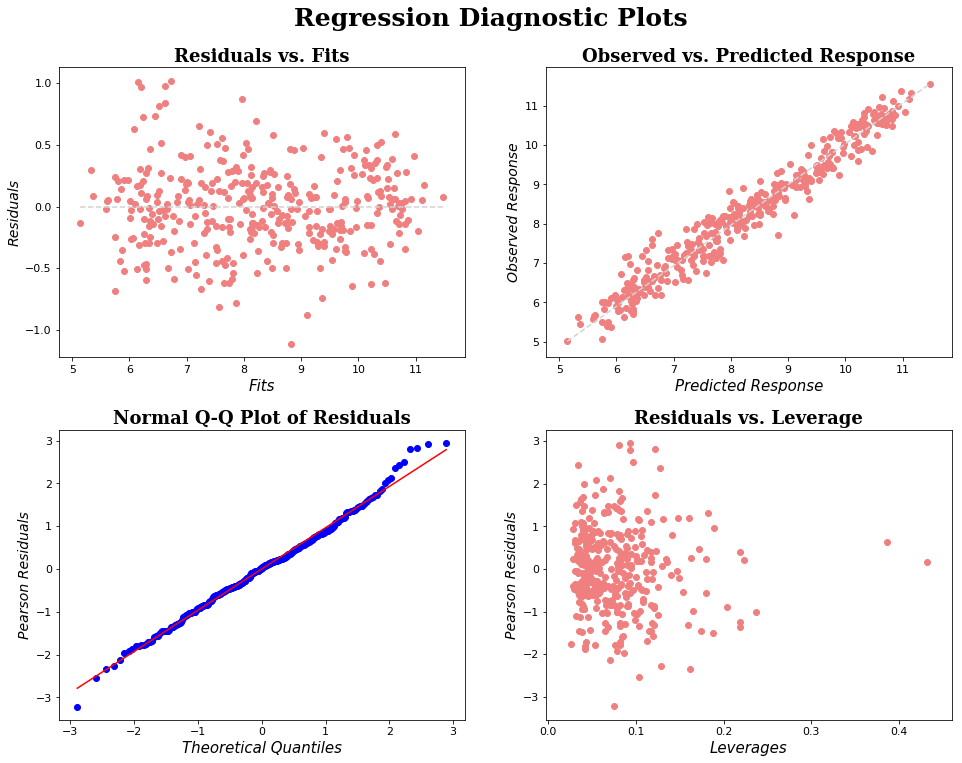

In [50]:
diagnostic_plots(fit_base, y_train)

In [51]:
#High leverage observations
influence_base = fit_base.get_influence()
train[influence_base.hat_matrix_diag > 0.3]

,Country,Year,exp_imp,gva_servc,labor_part,food_prod,life_exp,pop_gain,urban,log_gdp,log_pop_density,log_pop,log_gender_ratio,log_energy_prod,log_energy_supp,sqrt_internet,log_edu_prim,sqrt_gva_ag,sqrt_gva_indst,sqrt_unemp,log_tourism,log_health,sqrt_parliam_women,log_cpi,log_mort_child,log_mort_mother,log_num_child,log_pop_migrants,log_pop_unhcr,log_ghg_emissions
462,Qatar,2010,29058.989,32.392,86.7,132.1,77.0,14.4,98.5,11.161,5.032,0.577,5.748,8.336,6.485,8.307,3.909,0.342,8.215,0.707,8.827,0.582,0.000,4.656,2.054,2.773,0.788,4.404,6.568,3.667
600,United Arab Emirates,2010,1373.761,46.687,83.5,108.2,75.9,11.8,84.1,10.464,4.594,2.113,5.677,6.810,5.765,8.246,3.676,0.874,7.249,1.924,6.944,1.355,4.743,4.605,1.932,1.792,0.693,4.483,4.324,3.167


In [52]:
#No high Cook's distance observations
train[influence_base.cooks_distance[0] > 0.05]

,Country,Year,exp_imp,gva_servc,labor_part,food_prod,life_exp,pop_gain,urban,log_gdp,log_pop_density,log_pop,log_gender_ratio,log_energy_prod,log_energy_supp,sqrt_internet,log_edu_prim,sqrt_gva_ag,sqrt_gva_indst,sqrt_unemp,log_tourism,log_health,sqrt_parliam_women,log_cpi,log_mort_child,log_mort_mother,log_num_child,log_pop_migrants,log_pop_unhcr,log_ghg_emissions


In [53]:
#Store base model test predictions
y_pred = fit_base.predict(X_test)

In [54]:
#Variance inflation factors for all predictors - multicollinearity definitely an issue
vif = [{X_train.columns[i]: variance_inflation_factor(np.array(X_train), i)} for i in range(X_train.shape[1])]
vif

[{'Intercept': 9309.498722129942},
 {'exp_imp': 2.029895470449015},
 {'gva_servc': 18.94641503945681},
 {'labor_part': 1.742024424462108},
 {'food_prod': 1.3702744798931572},
 {'life_exp': 8.379728961466888},
 {'pop_gain': 6.755759246530341},
 {'urban': 3.1392600526571957},
 {'log_pop_density': 1.8875186138611706},
 {'log_pop': 2.533398879012364},
 {'log_gender_ratio': 4.984078054610872},
 {'log_energy_prod': 4.181373563746296},
 {'log_energy_supp': 9.646710124858425},
 {'sqrt_internet': 6.721523551627403},
 {'log_edu_prim': 2.0696160598776223},
 {'sqrt_gva_ag': 20.450632627414677},
 {'sqrt_gva_indst': 17.02074851926844},
 {'sqrt_unemp': 1.7072515328040574},
 {'log_tourism': 5.238515494355901},
 {'log_health': 2.099865732026329},
 {'sqrt_parliam_women': 1.5142338879045263},
 {'log_cpi': 1.2244260248962107},
 {'log_mort_child': 16.545274020637684},
 {'log_mort_mother': 13.281070985192386},
 {'log_num_child': 8.047631031029212},
 {'log_pop_migrants': 3.015491085019373},
 {'log_pop_unhcr'

In [55]:
#Take a look at correlation matrix for high-VIF features
X_train[['gva_servc', 'life_exp', 'pop_gain', 'log_energy_supp', 'sqrt_internet', 
   'sqrt_gva_ag', 'sqrt_gva_indst', 'log_tourism', 'log_mort_child', 
   'log_mort_mother', 'log_num_child', 'log_ghg_emissions']].corr()

,gva_servc,life_exp,pop_gain,log_energy_supp,sqrt_internet,sqrt_gva_ag,sqrt_gva_indst,log_tourism,log_mort_child,log_mort_mother,log_num_child,log_ghg_emissions
gva_servc,1.000,0.526,-0.396,0.311,0.577,-0.483,-0.571,0.622,-0.596,-0.498,-0.499,0.234
life_exp,0.526,1.000,-0.346,0.689,0.786,-0.678,0.080,0.711,-0.889,-0.879,-0.803,0.597
pop_gain,-0.396,-0.346,1.000,-0.179,-0.292,0.169,0.151,-0.177,0.358,0.373,0.570,-0.125
log_energy_supp,0.311,0.689,-0.179,1.000,0.769,-0.782,0.338,0.663,-0.790,-0.816,-0.733,0.848
sqrt_internet,0.577,0.786,-0.292,0.769,1.000,-0.734,0.039,0.738,-0.890,-0.830,-0.745,0.663
sqrt_gva_ag,-0.483,-0.678,0.169,-0.782,-0.734,1.000,-0.389,-0.714,0.752,0.739,0.659,-0.762
sqrt_gva_indst,-0.571,0.080,0.151,0.338,0.039,-0.389,1.000,-0.055,-0.040,-0.149,-0.113,0.399
log_tourism,0.622,0.711,-0.177,0.663,0.738,-0.714,-0.055,1.000,-0.764,-0.707,-0.624,0.639
log_mort_child,-0.596,-0.889,0.358,-0.790,-0.890,0.752,-0.040,-0.764,1.000,0.927,0.837,-0.686
log_mort_mother,-0.498,-0.879,0.373,-0.816,-0.830,0.739,-0.149,-0.707,0.927,1.000,0.853,-0.724


In [56]:
def lr_lasso_ridge_Train_CV(predictors, response, k = 10, random_state = None):
    """
    Takes a dataframe of predictors and a dataframe of responses (training data), 
    finds optimal ridge and LASSO alpha values via cross-validation, conducts k-fold 
    cross-validation with k folds, fits linear regression, ridge, and LASSO models to
    the data, and returns a dataframe with the R^2, RMSE, and MAE values for both the
    training and validation sets of each fold for all three models. 
    
    Parameters
    -----------
    predictors: dataframe 
        predictor features as columns and training data as rows
    response: 1-column dataframe
        training data response values as rows
    k: int 
        number of folds to use for k-fold cross-validation (default is 10)
    random_state: int
        random state value to use for k-fold cross-validation (default is None) 
    
    Returns
    --------
    Dataframe with 18 rows and (k + 1) columns. Rows correspond to training and 
    validation set R^2 scores, RMSE values, and MAE values for linear regression (LR),
    LASSO (L1), and ridge (L2) models. Columns correspond to the kth fold, with the
    final column being the mean value of each row. 
    """
    
    #Find best alpha for Ridge and Lasso using k-fold CV on training set
    alphavec = 10**np.linspace(-2, 2, 200)
    lasso_best_alpha_model = LassoCV(alphas = alphavec, cv = k, random_state = random_state)
    lasso_best_alpha = lasso_best_alpha_model.fit(predictors, response.iloc[:, 0]).alpha_

    ridge_best_alpha_model = RidgeCV(alphas = alphavec, cv = k)
    ridge_best_alpha = ridge_best_alpha_model.fit(predictors, response.iloc[:, 0]).alpha_

    #Setup k-fold CV method
    kf = KFold(n_splits = k, shuffle = True, random_state = random_state)
    
    #Initialize empty vectors for metrics
    lr_r2_tr = []
    lr_r2_te = []
    lr_rmse_tr = []
    lr_rmse_te = []
    lr_mae_tr = []
    lr_mae_te = []
    
    l1_r2_tr = []
    l1_r2_te = []
    l1_rmse_tr = []
    l1_rmse_te = []
    l1_mae_tr = []
    l1_mae_te = []
    
    l2_r2_tr = []
    l2_r2_te = []
    l2_rmse_tr = []
    l2_rmse_te = []
    l2_mae_tr = []
    l2_mae_te = []
    
    for tr, val in kf.split(predictors, response):

        #Split into train and validation sets for each fold
        X_tr, X_val = predictors.iloc[tr], predictors.iloc[val]
        y_tr, y_val = response.iloc[tr], response.iloc[val]

        #Scale using the train set and apply scaling to train and val sets
        scale = StandardScaler().fit(X_tr)
        X_tr = scale.transform(X_tr)
        X_val = scale.transform(X_val)

        #Fit models, using best alphas for ridge and lasso
        lr = LinearRegression().fit(X_tr, y_tr)
        l1 = Lasso(alpha = lasso_best_alpha).fit(X_tr, y_tr)
        l2 = Ridge(alpha = ridge_best_alpha).fit(X_tr, y_tr)

        #Calculate R^2, RMSE, and MAE for each model/fold for train and val splits
        lr_r2_tr.append(r2_score(y_tr, lr.predict(X_tr)))
        lr_r2_te.append(r2_score(y_val, lr.predict(X_val)))
        lr_rmse_tr.append(np.sqrt(mean_squared_error(y_tr, lr.predict(X_tr))))
        lr_rmse_te.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
        lr_mae_tr.append(mean_absolute_error(y_tr, lr.predict(X_tr)))
        lr_mae_te.append(mean_absolute_error(y_val, lr.predict(X_val)))
        
        l1_r2_tr.append(r2_score(y_tr, l1.predict(X_tr)))
        l1_r2_te.append(r2_score(y_val, l1.predict(X_val)))
        l1_rmse_tr.append(np.sqrt(mean_squared_error(y_tr, l1.predict(X_tr))))
        l1_rmse_te.append(np.sqrt(mean_squared_error(y_val, l1.predict(X_val))))
        l1_mae_tr.append(mean_absolute_error(y_tr, l1.predict(X_tr)))
        l1_mae_te.append(mean_absolute_error(y_val, l1.predict(X_val)))
        
        l2_r2_tr.append(r2_score(y_tr, l2.predict(X_tr)))
        l2_r2_te.append(r2_score(y_val, l2.predict(X_val)))
        l2_rmse_tr.append(np.sqrt(mean_squared_error(y_tr, l2.predict(X_tr))))
        l2_rmse_te.append(np.sqrt(mean_squared_error(y_val, l2.predict(X_val))))
        l2_mae_tr.append(mean_absolute_error(y_tr, l2.predict(X_tr)))
        l2_mae_te.append(mean_absolute_error(y_val, l2.predict(X_val)))
        
    #Store metrics in dataframe output
    metrics = pd.DataFrame([lr_r2_tr, lr_r2_te, lr_rmse_tr, lr_rmse_te, lr_mae_tr, lr_mae_te, 
                            l1_r2_tr, l1_r2_te, l1_rmse_tr, l1_rmse_te, l1_mae_tr, l1_mae_te, 
                            l2_r2_tr, l2_r2_te, l2_rmse_tr, l2_rmse_te, l2_mae_tr, l2_mae_te],
                           index = ['lr_r2_tr', 'lr_r2_te', 'lr_rmse_tr', 'lr_rmse_te', 
                                    'lr_mae_tr', 'lr_mae_te', 'l1_r2_tr', 'l1_r2_te', 
                                    'l1_rmse_tr', 'l1_rmse_te', 'l1_mae_tr', 'l1_mae_te', 
                                    'l2_r2_tr', 'l2_r2_te', 'l2_rmse_tr', 'l2_rmse_te', 
                                    'l2_mae_tr', 'l2_mae_te'])
    
    #Calculate means across folds
    metrics['means'] = metrics.apply(np.mean, axis = 1)
    return metrics

In [57]:
#Ridge and LASSO appear to offer no improvement
lr_lasso_ridge_Train_CV(X_train, y_train, random_state = 436)

,0,1,2,3,4,5,6,7,8,9,means
lr_r2_tr,0.958,0.953,0.957,0.954,0.952,0.954,0.954,0.952,0.954,0.954,0.954
lr_r2_te,0.900,0.951,0.906,0.940,0.962,0.949,0.943,0.971,0.948,0.946,0.942
lr_rmse_tr,0.319,0.338,0.324,0.330,0.334,0.334,0.327,0.342,0.330,0.330,0.331
lr_rmse_te,0.448,0.298,0.423,0.370,0.336,0.339,0.413,0.248,0.367,0.374,0.362
lr_mae_tr,0.248,0.262,0.251,0.256,0.258,0.260,0.253,0.265,0.257,0.258,0.257
lr_mae_te,0.338,0.223,0.327,0.308,0.276,0.266,0.328,0.192,0.287,0.296,0.284
l1_r2_tr,0.951,0.947,0.950,0.950,0.946,0.947,0.948,0.946,0.948,0.948,0.948
l1_r2_te,0.895,0.948,0.914,0.925,0.957,0.962,0.937,0.962,0.940,0.936,0.938
l1_rmse_tr,0.343,0.359,0.348,0.347,0.355,0.357,0.348,0.362,0.351,0.351,0.352
l1_rmse_te,0.459,0.306,0.404,0.413,0.358,0.292,0.435,0.286,0.394,0.406,0.375


In [58]:
def lr_lasso_ridge_Train_Test(pred_train, pred_test, resp_train, resp_test, k = 10, random_state = None):
    """
    Takes 4 dataframes corresponding to the predictor training set, predictor test set, 
    response training set, and response test set, finds optimal ridge and LASSO alpha values 
    via cross-validation on the training set, fits linear regression, ridge, and LASSO models to
    the training data, and returns printed output reporting the R^2, RMSE, and MAE for both the 
    training and test sets for all three models. 
    
    Parameters
    -----------
    pred_train: dataframe 
        predictor features as columns and training data as rows
    pred_test: dataframe 
        predictor features as columns and test data as rows
    resp_train: 1-column dataframe
        training data response values as rows
    resp_test: 1-column dataframe
        test data response values as rows
    k: int 
        number of folds to use for ridge and LASSO cross-validation (default is 10)
    random_state: int
        random state value to use for ridge and LASSO cross-validation (default is None) 
    
    Returns
    --------
    18 lines of printed text output reporting the R^2 score, RMSE value, and MAE value
    for the training and test data of the linear regression (lin reg), LASSO (L1), and 
    ridge (L2) models. 
    """
    
    #Find best alpha for Ridge and Lasso using k-fold CV on training set
    alphavec = 10**np.linspace(-2, 2, 200)
    lasso_best_alpha_model = LassoCV(alphas = alphavec, cv = k, random_state = random_state)
    lasso_best_alpha = lasso_best_alpha_model.fit(pred_train, resp_train.iloc[:, 0]).alpha_

    ridge_best_alpha_model = RidgeCV(alphas = alphavec, cv = k)
    ridge_best_alpha = ridge_best_alpha_model.fit(pred_train, resp_train.iloc[:, 0]).alpha_
    
    #Scale using training set and apply scaling to train and test sets
    scale = StandardScaler().fit(pred_train)
    pred_train_scale = scale.transform(pred_train)
    pred_test_scale = scale.transform(pred_test)

    #Fit models
    lr_model = LinearRegression().fit(pred_train_scale, resp_train)
    l1_model = Lasso(alpha = lasso_best_alpha).fit(pred_train_scale, resp_train)
    l2_model = Ridge(alpha = ridge_best_alpha).fit(pred_train_scale, resp_train)
    
    #Print R^2, RMSE, and MAE values for train and test sets
    print('lin reg train R2: ', r2_score(resp_train, lr_model.predict(pred_train_scale)))
    print('lin reg test R2: ', r2_score(resp_test, lr_model.predict(pred_test_scale)), '\n')
    print('lin reg train RMSE: ', np.sqrt(mean_squared_error(resp_train, lr_model.predict(pred_train_scale))))
    print('lin reg test RMSE: ', np.sqrt(mean_squared_error(resp_test, lr_model.predict(pred_test_scale))), '\n')
    print('lin reg train MAE: ', mean_absolute_error(resp_train, lr_model.predict(pred_train_scale)))
    print('lin reg test MAE: ', mean_absolute_error(resp_test, lr_model.predict(pred_test_scale)), '\n')
    print('lasso train R2: ', r2_score(resp_train, l1_model.predict(pred_train_scale)))
    print('lasso test R2: ', r2_score(resp_test, l1_model.predict(pred_test_scale)), '\n')
    print('lasso train RMSE: ', np.sqrt(mean_squared_error(resp_train, l1_model.predict(pred_train_scale))))
    print('lasso test RMSE: ', np.sqrt(mean_squared_error(resp_test, l1_model.predict(pred_test_scale))), '\n')
    print('lasso train MAE: ', mean_absolute_error(resp_train, l1_model.predict(pred_train_scale)))
    print('lasso test MAE: ', mean_absolute_error(resp_test, l1_model.predict(pred_test_scale)), '\n')
    print('ridge train R2: ', r2_score(resp_train, l2_model.predict(pred_train_scale)))
    print('ridge test R2: ', r2_score(resp_test, l2_model.predict(pred_test_scale)), '\n')
    print('ridge train RMSE: ', np.sqrt(mean_squared_error(resp_train, l2_model.predict(pred_train_scale))))
    print('ridge test RMSE: ', np.sqrt(mean_squared_error(resp_test, l2_model.predict(pred_test_scale))), '\n')
    print('ridge train MAE: ', mean_absolute_error(resp_train, l2_model.predict(pred_train_scale)))
    print('ridge test MAE: ', mean_absolute_error(resp_test, l2_model.predict(pred_test_scale)))

In [59]:
lr_lasso_ridge_Train_Test(X_train, X_test, y_train, y_test, random_state = 436)

lin reg train R2:  0.9536186013115764
lin reg test R2:  0.8972338803431027 

lin reg train RMSE:  0.3326883236916999
lin reg test RMSE:  0.4539443793371443 

lin reg train MAE:  0.2585064075069598
lin reg test MAE:  0.34137100644752033 

lasso train R2:  0.9474454216263737
lasso test R2:  0.8916254110853463 

lasso train RMSE:  0.3541366839191416
lasso test RMSE:  0.4661668593611597 

lasso train MAE:  0.2793991880725797
lasso test MAE:  0.360192927310707 

ridge train R2:  0.9515632404597001
ridge test R2:  0.895346315279939 

ridge train RMSE:  0.3399798504889088
ridge test RMSE:  0.4580943400202068 

ridge train MAE:  0.2667668538565586
ridge test MAE:  0.34691041077700907


In [60]:
#Re-fit previous models to store and access model output
k = 10
alphavec = 10**np.linspace(-2, 2, 200)
lasso_best_alpha_model = LassoCV(alphas = alphavec, cv = k, random_state = 436)
lasso_best_alpha = lasso_best_alpha_model.fit(X_train, y_train.iloc[:, 0]).alpha_

ridge_best_alpha_model = RidgeCV(alphas = alphavec, cv = k)
ridge_best_alpha = ridge_best_alpha_model.fit(X_train, y_train.iloc[:, 0]).alpha_

scale = StandardScaler().fit(X_train)
X_train_scale = scale.transform(X_train)
X_test_scale = scale.transform(X_test)

lr_model = LinearRegression().fit(X_train_scale, y_train)
l1_model = Lasso(alpha = lasso_best_alpha).fit(X_train_scale, y_train)
l2_model = Ridge(alpha = ridge_best_alpha).fit(X_train_scale, y_train)

In [185]:
# compile standardized coefficients from lr model fit to scaled data for feature weight comparison
scaled_coef = pd.DataFrame(data = {'Feature': X_train.columns[1:].tolist(), 
                                   'Coefficient': lr_model.coef_[0][1:].tolist()})
scaled_coef.sort_values('Coefficient')

,Feature,Coefficient
14,sqrt_gva_ag,-0.946
1,gva_servc,-0.475
15,sqrt_gva_indst,-0.440
21,log_mort_child,-0.212
7,log_pop_density,-0.145
2,labor_part,-0.073
16,sqrt_unemp,-0.064
5,pop_gain,-0.044
22,log_mort_mother,-0.032
10,log_energy_prod,-0.024


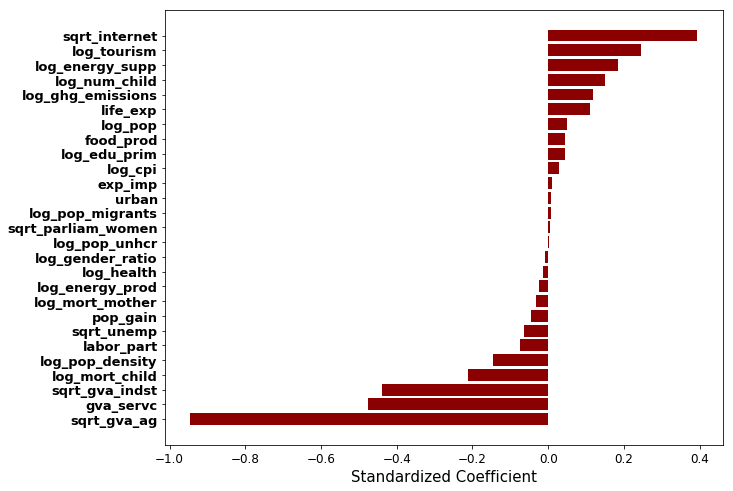

In [186]:
# barplot of standardized coefficients from linear regression model
plt.figure(figsize = (10, 8))
plt.barh(scaled_coef.sort_values('Coefficient').Feature, 
         scaled_coef.sort_values('Coefficient').Coefficient, color = 'darkred')
plt.yticks(fontsize = 13, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.xlabel('Standardized Coefficient', fontsize = 15)

plt.savefig('lin_reg_standard_coeff.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

In [61]:
#Display LASSO coefficients sorted by absolute value - removed features shown first
lasso_coef = {X_train.columns[i]: l1_model.coef_[i] for i in range(X_train.shape[1])}
sorted(lasso_coef.items(), key = lambda x: np.abs(x[1]))

[('Intercept', 0.0),
 ('pop_gain', 0.0),
 ('log_pop', 0.0),
 ('log_gender_ratio', -0.0),
 ('log_energy_prod', 0.0),
 ('log_health', 0.0),
 ('sqrt_parliam_women', 0.0),
 ('log_mort_mother', -0.0),
 ('log_pop_unhcr', 0.0),
 ('sqrt_gva_indst', -0.0014683337036092731),
 ('exp_imp', 0.01291076736551593),
 ('gva_servc', -0.014082087022473253),
 ('log_cpi', 0.023962296350043884),
 ('log_pop_migrants', 0.02423609675798066),
 ('urban', 0.029903569624591807),
 ('log_edu_prim', 0.03327298748908943),
 ('food_prod', 0.03523061225922358),
 ('life_exp', 0.046919182123365),
 ('labor_part', -0.05666283204050682),
 ('sqrt_unemp', -0.06210102995951846),
 ('log_num_child', 0.09222507316433624),
 ('log_pop_density', -0.094306279519504),
 ('log_ghg_emissions', 0.1511307548997421),
 ('log_energy_supp', 0.17050744697396994),
 ('log_tourism', 0.2340793306278342),
 ('log_mort_child', -0.23968672448747472),
 ('sqrt_internet', 0.40171403042352266),
 ('sqrt_gva_ag', -0.496373385930803)]

In [62]:
#Put the LASSO-removed features in a list
lasso_removed = [key for (key, value) in lasso_coef.items() if (value == 0) & (key != 'Intercept')]
lasso_removed

['pop_gain',
 'log_pop',
 'log_gender_ratio',
 'log_energy_prod',
 'log_health',
 'sqrt_parliam_women',
 'log_mort_mother',
 'log_pop_unhcr']

In [63]:
#Ridge coefficients sorted by absolute value
ridge_coef = {X_train.columns[i]: l2_model.coef_[0][i] for i in range(X_train.shape[1])}
sorted(ridge_coef.items(), key = lambda x: np.abs(x[1]))

[('Intercept', 0.0),
 ('log_energy_prod', -0.002383900449375502),
 ('log_pop_unhcr', 0.004737613873274624),
 ('sqrt_parliam_women', 0.00726150084796406),
 ('log_health', -0.008851397091335323),
 ('pop_gain', -0.011865668631213144),
 ('log_gender_ratio', -0.019332595639980146),
 ('exp_imp', 0.019488726249985894),
 ('log_pop_migrants', 0.02096474314387024),
 ('log_pop', 0.021862717097974754),
 ('log_mort_mother', -0.029426161024981648),
 ('urban', 0.029516817142870005),
 ('log_cpi', 0.030281427895588138),
 ('food_prod', 0.042651353238588756),
 ('log_edu_prim', 0.04797437752397968),
 ('sqrt_unemp', -0.06576729757087153),
 ('labor_part', -0.07223453532997695),
 ('life_exp', 0.09060478595771372),
 ('log_pop_density', -0.11315560841372406),
 ('log_num_child', 0.13447102813561926),
 ('log_ghg_emissions', 0.15032707712749935),
 ('sqrt_gva_indst', -0.18401369275932744),
 ('log_energy_supp', 0.1840218451956734),
 ('gva_servc', -0.19538542684848842),
 ('log_mort_child', -0.2275254091315219),
 ('l

In [64]:
#Try modelling with different train/test sets after reducing feature space
#First combination removes features with high p-values in base model
X_train2 = X_train.drop(columns = insig_features)
X_test2 = X_test.drop(columns = insig_features)

#Second combination only removes features initially cut by LASSO
X_train3 = X_train.drop(columns = lasso_removed)
X_test3 = X_test.drop(columns = lasso_removed)

In [65]:
#LASSO and Ridge still offer no improvement - focus on normal LR going forward
lr_lasso_ridge_Train_CV(X_train2, y_train, random_state = 436)

,0,1,2,3,4,5,6,7,8,9,means
lr_r2_tr,0.957,0.953,0.956,0.954,0.951,0.952,0.953,0.951,0.953,0.953,0.953
lr_r2_te,0.907,0.951,0.910,0.936,0.967,0.954,0.949,0.972,0.948,0.950,0.944
lr_rmse_tr,0.324,0.341,0.327,0.332,0.338,0.338,0.332,0.344,0.333,0.334,0.334
lr_rmse_te,0.432,0.297,0.413,0.381,0.315,0.321,0.389,0.245,0.366,0.361,0.352
lr_mae_tr,0.253,0.265,0.254,0.258,0.261,0.263,0.255,0.268,0.257,0.261,0.260
lr_mae_te,0.324,0.227,0.317,0.316,0.259,0.239,0.313,0.191,0.290,0.281,0.276
l1_r2_tr,0.951,0.947,0.951,0.950,0.945,0.947,0.947,0.946,0.948,0.948,0.948
l1_r2_te,0.901,0.950,0.913,0.923,0.963,0.963,0.944,0.962,0.939,0.936,0.939
l1_rmse_tr,0.343,0.360,0.347,0.347,0.357,0.356,0.350,0.362,0.351,0.351,0.352
l1_rmse_te,0.446,0.302,0.407,0.418,0.333,0.290,0.408,0.284,0.395,0.406,0.369


In [66]:
lr_lasso_ridge_Train_Test(X_train2, X_test2, y_train, y_test, random_state = 436)

lin reg train R2:  0.9528834986220783
lin reg test R2:  0.9049283127598228 

lin reg train RMSE:  0.3353143621341356
lin reg test RMSE:  0.4366196374164449 

lin reg train MAE:  0.26040275085299397
lin reg test MAE:  0.3294597043469301 

lasso train R2:  0.9476561907088786
lasso test R2:  0.8968708852476577 

lasso train RMSE:  0.3534258414642287
lasso test RMSE:  0.45474539396053953 

lasso train MAE:  0.27998364745821563
lasso test MAE:  0.3532665461243836 

ridge train R2:  0.9515648348392829
ridge test R2:  0.902140993143 

ridge train RMSE:  0.33997425493092687
ridge test RMSE:  0.4429738260866743 

ridge train MAE:  0.2671758926909387
ridge test MAE:  0.33839642510473117


In [67]:
lr_lasso_ridge_Train_CV(X_train3, y_train, random_state = 436)

,0,1,2,3,4,5,6,7,8,9,means
lr_r2_tr,0.957,0.952,0.956,0.954,0.951,0.952,0.953,0.951,0.953,0.953,0.953
lr_r2_te,0.902,0.951,0.911,0.935,0.965,0.958,0.944,0.971,0.947,0.949,0.943
lr_rmse_tr,0.323,0.341,0.328,0.332,0.338,0.340,0.331,0.344,0.333,0.334,0.334
lr_rmse_te,0.443,0.298,0.412,0.386,0.323,0.305,0.408,0.250,0.369,0.364,0.356
lr_mae_tr,0.252,0.266,0.255,0.258,0.263,0.266,0.256,0.271,0.259,0.262,0.261
lr_mae_te,0.336,0.232,0.321,0.323,0.267,0.229,0.324,0.196,0.289,0.282,0.280
l1_r2_tr,0.951,0.947,0.950,0.950,0.946,0.947,0.948,0.946,0.948,0.948,0.948
l1_r2_te,0.896,0.949,0.914,0.925,0.957,0.962,0.937,0.962,0.940,0.938,0.938
l1_rmse_tr,0.343,0.360,0.348,0.347,0.355,0.357,0.348,0.362,0.351,0.352,0.352
l1_rmse_te,0.457,0.304,0.404,0.412,0.357,0.291,0.435,0.286,0.392,0.401,0.374


In [68]:
lr_lasso_ridge_Train_Test(X_train3, X_test3, y_train, y_test, random_state = 436)

lin reg train R2:  0.9527758741237868
lin reg test R2:  0.8972443534660282 

lin reg train RMSE:  0.33569710972976724
lin reg test RMSE:  0.453921247509085 

lin reg train MAE:  0.26185512418034607
lin reg test MAE:  0.345305272137858 

lasso train R2:  0.947445062090309
lasso test R2:  0.8916531351509925 

lasso train RMSE:  0.3541378952759433
lasso test RMSE:  0.4661072288361739 

lasso train MAE:  0.2793984055611558
lasso test MAE:  0.36012205073256065 

ridge train R2:  0.9512941262368267
ridge test R2:  0.895034450442577 

ridge train RMSE:  0.3409230048388921
ridge test RMSE:  0.4587763859666494 

ridge train MAE:  0.26778511987991
ridge test MAE:  0.3501335166910628


In [69]:
def aic(y_obs, y_pred, p):
    """
    Takes two 1-D arrays or 1-column dataframes representing the 
    observed and predicted response values of a linear regression 
    training dataset, as well as the number of model parameters (p), 
    and returns the AIC statistic calculated using the following 
    formula:
    
    (n)ln(RSS) - (n)ln(n) + 2p
    
    Parameters
    ----------
    y_obs: 1-column dataframe or 1-D array
        observed ('true') response values of training dataset
    y_pred: 1-column dataframe or 1-D array
        response values of training dataset predicted using linear 
        regression
    p: int
        number of parameters of linear regression model (including 
        intercept)
    
    Returns
    -------
    AIC statistic (float) of linear regression model.
    """
    n = len(y_obs)
    SSE = np.sum((np.array(y_obs) - np.array(y_pred))**2)
    return (n * np.log(SSE)) - (n * np.log(n)) + (2 * p)

def bic(y_obs, y_pred, p):
    """
    Takes two 1-D arrays or 1-column dataframes representing the 
    observed and predicted response values of a linear regression 
    training dataset, as well as the number of model parameters (p), 
    and returns the BIC statistic calculated using the following 
    formula:
    
    (n)ln(RSS) - (n)ln(n) + (p)ln(n)
    
    Parameters
    ----------
    y_obs: 1-column dataframe or 1-D array
        observed ('true') response values of training dataset
    y_pred: 1-column dataframe or 1-D array
        response values of training dataset predicted using linear 
        regression
    p: int
        number of parameters of linear regression model (including 
        intercept)
    
    Returns
    -------
    BIC statistic (float) of linear regression model.
    """
    n = len(y_obs)
    SSE = np.sum((np.array(y_obs) - np.array(y_pred))**2)
    return (n * np.log(SSE)) - (n * np.log(n)) + (p * np.log(n))

def adj_r2(y_obs, y_pred, p):
    """
    Takes two 1-D arrays or 1-column dataframes representing the 
    observed and predicted response values of a linear regression 
    training dataset, as well as the number of model parameters (p), 
    and returns the Adjusted R^2 score.
    
    Parameters
    ----------
    y_obs: 1-column dataframe or 1-D array
        observed ('true') response values of training dataset
    y_pred: 1-column dataframe or 1-D array
        response values of training dataset predicted using linear 
        regression
    p: int
        number of parameters of linear regression model (including 
        intercept)
    
    Returns
    -------
    Adjusted R^2 score (float) of linear regression model.
    """
    n = len(y_obs)
    SSE = np.sum((np.array(y_obs) - np.array(y_pred))**2)
    SST = np.sum((np.array(y_obs) - float(np.mean(y_obs)))**2)
    return 1 - ((SSE / (n - p - 1)) / (SST / (n - 1)))

In [70]:
def lr_Train_CV(predictors, response, k = 10, random_state = None):
    """
    Takes a dataframe of predictors and a dataframe of responses (training data), 
    conducts k-fold cross-validation with k folds, fits a linear regression model to
    the (unscaled) data, and returns a dataframe with the R^2, Adjusted R^2, RMSE, 
    MAE, AIC, and BIC values for both the training and validation sets of each fold. 
    
    Parameters
    -----------
    predictors: dataframe 
        predictor features as columns and training data as rows
    response: 1-column dataframe
        training data response values as rows
    k: int 
        number of folds to use for k-fold cross-validation (default is 10)
    random_state: int
        random state value to use for k-fold cross-validation (default is None) 
    
    Returns
    --------
    Dataframe with 12 rows and (k + 1) columns. Rows correspond to training and 
    validation set R^2 scores, Adjusted R^2 scores, RMSE values, MAE values, AIC 
    statistics, and BIC statistics for the linear regression model. Columns 
    correspond to the kth fold, with the final column being the mean value of each row. 
    """
    
    #Setup k-fold CV method
    kf = KFold(n_splits = k, shuffle = True, random_state = random_state)
    
    #Initialize empty vectors for metrics
    r2_tr = []
    r2_te = []
    adj_r2_tr = []
    adj_r2_te = []
    rmse_tr = []
    rmse_te = []
    mae_tr = []
    mae_te = []
    aic_tr = []
    aic_te = []
    bic_tr = []
    bic_te = []
    
    for tr, val in kf.split(predictors, response):

        #Split into train and validation sets for each fold
        X_tr, X_val = predictors.iloc[tr], predictors.iloc[val]
        y_tr, y_val = response.iloc[tr], response.iloc[val]
        
        #Fit model
        lr = LinearRegression().fit(X_tr, y_tr)
        
        #Calculate R^2, Adj_R^2, RMSE, MAE, AIC, and BIC for each fold for train and val splits
        r2_tr.append(r2_score(y_tr, lr.predict(X_tr)))
        r2_te.append(r2_score(y_val, lr.predict(X_val)))
        adj_r2_tr.append(adj_r2(y_tr, lr.predict(X_tr), lr.rank_))
        adj_r2_te.append(adj_r2(y_val, lr.predict(X_val), lr.rank_))
        rmse_tr.append(np.sqrt(mean_squared_error(y_tr, lr.predict(X_tr))))
        rmse_te.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
        mae_tr.append(mean_absolute_error(y_tr, lr.predict(X_tr)))
        mae_te.append(mean_absolute_error(y_val, lr.predict(X_val)))
        aic_tr.append(aic(y_tr, lr.predict(X_tr), lr.rank_))
        aic_te.append(aic(y_val, lr.predict(X_val), lr.rank_))
        bic_tr.append(bic(y_tr, lr.predict(X_tr), lr.rank_))
        bic_te.append(bic(y_val, lr.predict(X_val), lr.rank_))
        
        #Store metrics in dataframe output
        metrics = pd.DataFrame([r2_tr, r2_te, adj_r2_tr, adj_r2_te, rmse_tr, rmse_te, 
                                mae_tr, mae_te, aic_tr, aic_te, bic_tr, bic_te],
                               index = ['r2_train', 'r2_val', 'adj_r2_train', 'adj_r2_val', 
                                        'rmse_train', 'rmse_val', 'mae_train', 'mae_val', 
                                        'aic_train', 'aic_val', 'bic_train', 'bic_val'])
    
    metrics['means'] = metrics.apply(np.mean, axis = 1)
    return metrics   

In [71]:
#Model with training data that removed the most features (X_train2; removed features 
#deemed insignificant by base model) seems to do the best on validation data
lr_Train_CV(X_train, y_train, random_state = 436)

,0,1,2,3,4,5,6,7,8,9,means
r2_train,0.957,0.953,0.956,0.954,0.952,0.954,0.954,0.951,0.954,0.954,0.954
r2_val,0.901,0.954,0.908,0.940,0.962,0.949,0.944,0.971,0.947,0.946,0.942
adj_r2_train,0.953,0.948,0.952,0.950,0.947,0.949,0.949,0.946,0.949,0.949,0.949
adj_r2_val,0.554,0.791,0.540,0.699,0.808,0.743,0.720,0.856,0.737,0.764,0.721
rmse_train,0.321,0.340,0.325,0.331,0.334,0.334,0.328,0.345,0.331,0.330,0.332
rmse_val,0.446,0.290,0.418,0.371,0.338,0.339,0.409,0.247,0.368,0.374,0.360
mae_train,0.251,0.266,0.253,0.256,0.258,0.260,0.255,0.270,0.257,0.258,0.258
mae_val,0.338,0.215,0.324,0.308,0.277,0.267,0.323,0.202,0.287,0.296,0.284
aic_train,-682.420,-646.152,-675.831,-665.855,-658.299,-658.917,-670.557,-638.054,-665.555,-667.964,-662.961
aic_val,-3.710,-35.563,-6.810,-15.489,-22.024,-21.801,-8.396,-44.624,-16.063,-16.811,-19.129


In [72]:
lr_Train_CV(X_train2, y_train, random_state = 436)

,0,1,2,3,4,5,6,7,8,9,means
r2_train,0.957,0.953,0.956,0.954,0.951,0.952,0.953,0.951,0.953,0.953,0.953
r2_val,0.907,0.951,0.910,0.936,0.967,0.954,0.949,0.972,0.948,0.950,0.944
adj_r2_train,0.954,0.950,0.954,0.951,0.948,0.950,0.950,0.948,0.951,0.950,0.951
adj_r2_val,0.832,0.913,0.834,0.883,0.939,0.915,0.906,0.948,0.904,0.907,0.898
rmse_train,0.324,0.341,0.327,0.332,0.338,0.338,0.332,0.344,0.333,0.334,0.334
rmse_val,0.432,0.297,0.413,0.381,0.315,0.321,0.389,0.245,0.366,0.361,0.352
mae_train,0.253,0.265,0.254,0.258,0.261,0.263,0.255,0.268,0.257,0.261,0.260
mae_val,0.324,0.227,0.317,0.316,0.259,0.239,0.313,0.191,0.290,0.281,0.276
aic_train,-701.207,-668.200,-696.446,-686.713,-675.064,-675.563,-686.990,-663.392,-685.922,-683.381,-682.288
aic_val,-30.051,-57.902,-31.652,-37.497,-51.265,-49.730,-35.971,-69.156,-40.272,-41.295,-44.479


In [73]:
lr_Train_CV(X_train3, y_train, random_state = 436)

,0,1,2,3,4,5,6,7,8,9,means
r2_train,0.957,0.952,0.956,0.954,0.951,0.952,0.953,0.951,0.953,0.953,0.953
r2_val,0.902,0.951,0.911,0.935,0.965,0.958,0.944,0.971,0.947,0.949,0.943
adj_r2_train,0.954,0.949,0.953,0.951,0.948,0.949,0.950,0.948,0.950,0.950,0.950
adj_r2_val,0.793,0.896,0.804,0.857,0.924,0.909,0.878,0.936,0.884,0.888,0.877
rmse_train,0.323,0.341,0.328,0.332,0.338,0.340,0.331,0.344,0.333,0.334,0.334
rmse_val,0.443,0.298,0.412,0.386,0.323,0.305,0.408,0.250,0.369,0.364,0.356
mae_train,0.252,0.266,0.255,0.258,0.263,0.266,0.256,0.271,0.259,0.262,0.261
mae_val,0.336,0.232,0.321,0.323,0.267,0.229,0.324,0.196,0.289,0.282,0.280
aic_train,-696.050,-661.296,-688.118,-681.220,-669.495,-665.937,-683.436,-656.978,-679.673,-677.221,-675.942
aic_val,-22.283,-51.604,-25.854,-30.538,-43.341,-47.406,-26.545,-61.853,-33.692,-34.767,-37.788


In [74]:
#fit statsmodels linear regression model to X_train2 - performs better than base model,
#but still a high condition number (collinear predictors)
fit2 = sm.OLS(y_train, X_train2).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_gdp   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     436.1
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          1.00e-217
Time:                        23:33:39   Log-Likelihood:                -118.10
No. Observations:                 362   AIC:                             270.2
Df Residuals:                     345   BIC:                             336.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.7644      0.917     12.827      0.000       9.960      13.568
gva_servc            -0.0304      0.005     -6.163      0.000      -0.040      -0.021
labor_part           -0.0078      0.002     -3.831      0.000      -0.012      -0.004
food_prod             0.0033      0.001      2.385      0.018       0.001       0.006
life_exp              0.0116      0.005      2.364      0.019       0.002       0.021
log_pop_density      -0.1041      0.016     -6.352      0.000      -0.136      -0.072
log_pop               0.0198      0.012      1.599      0.111      -0.005       0.044
log_energy_supp       0.1349      0.039      3.493      0.001       0.059       0.211
sqrt_internet         0.1545      0.017      9.186      0.000       0.121       0.188
log_edu_prim          0.0780      0.042      1.854      0.065      -0.005       0.161
sqrt_gva_ag          -0.5419      0.045    -11.949      0.000      -0.631      -0.453
sqrt_gva_indst       -0.3504      0.058     -5.991      0.000      -0.465      -0.235
sqrt_unemp           -0.0609      0.023     -2.604      0.010      -0.107      -0.015
log_tourism           0.1048      0.018      5.695      0.000       0.069       0.141
log_mort_child       -0.2276      0.060     -3.765      0.000      -0.347      -0.109
log_num_child         0.2126      0.081      2.616      0.009       0.053       0.372
log_ghg_emissions     0.1236      0.039      3.200      0.002       0.048       0.200
==============================================================================
Omnibus:                        3.096   Durbin-Watson:                   1.279
Prob(Omnibus):                  0.213   Jarque-Bera (JB):                3.208
Skew:                           0.096   Prob(JB):                        0.201
Kurtosis:                       3.419   Cond. No.                     7.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

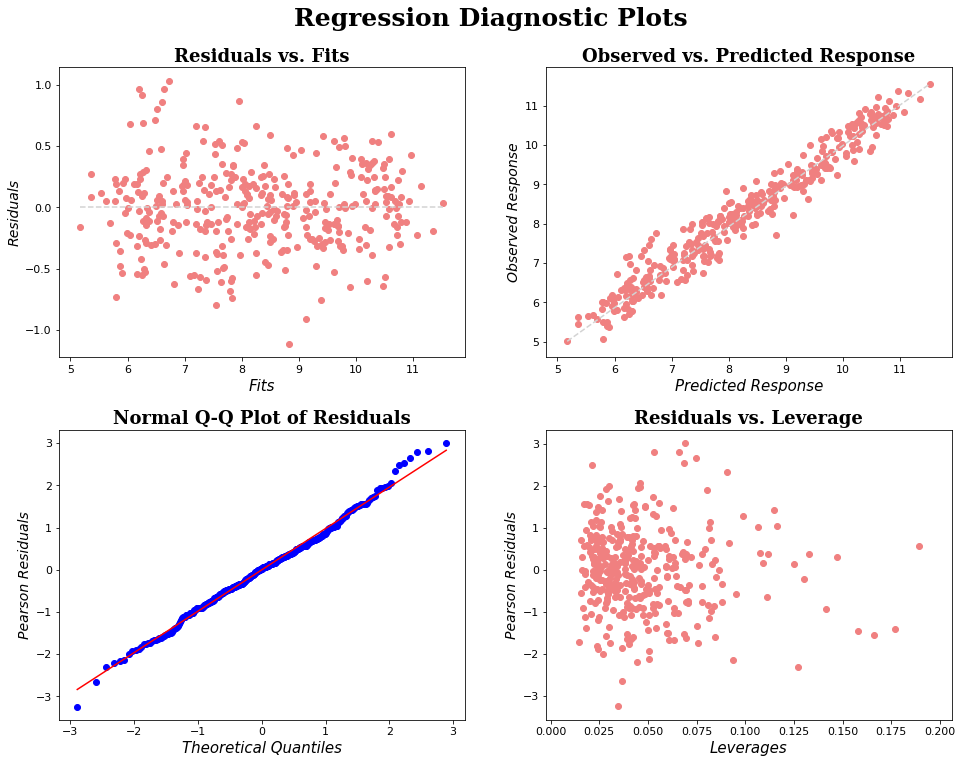

In [75]:
diagnostic_plots(fit2, y_train)

In [76]:
def lr_Train_Test(pred_train, pred_test, resp_train, resp_test):
    """
    Takes 4 dataframes corresponding to the predictor training set, predictor test set, 
    response training set, and response test set, fits a linear regression model to the 
    training data, and returns printed output reporting the R^2, Adjusted R^2, RMSE, MAE,
    AIC, and BIC values for both the training and test sets. 
    
    Parameters
    -----------
    pred_train: dataframe 
        predictor features as columns and training data as rows
    pred_test: dataframe 
        predictor features as columns and test data as rows
    resp_train: 1-column dataframe
        training data response values as rows
    resp_test: 1-column dataframe
        test data response values as rows 
    
    Returns
    --------
    12 lines of printed text output reporting the R^2 score, Adjusted R^2 score, RMSE 
    value, MAE value, AIC statistic, and BIC statistic for the training and test data of 
    the linear regression model. 
    """
    
    lr2 = LinearRegression().fit(pred_train, resp_train)
    lr2_train_pred = lr2.predict(pred_train)
    lr2_test_pred = lr2.predict(pred_test)
    
    print('Train R2: ', r2_score(resp_train, lr2_train_pred))
    print('Test R2: ', r2_score(resp_test, lr2_test_pred))
    print('Train Adj. R2: ', adj_r2(resp_train, lr2_train_pred, lr2.rank_)) 
    print('Test Adj. R2: ', adj_r2(resp_test, lr2_test_pred, lr2.rank_))
    print('Train RMSE: ', np.sqrt(mean_squared_error(resp_train, lr2_train_pred))) 
    print('Test RMSE: ', np.sqrt(mean_squared_error(resp_test, lr2_test_pred)))
    print('Train MAE: ', mean_absolute_error(resp_train, lr2_train_pred))
    print('Test MAE: ', mean_absolute_error(resp_test, lr2_test_pred))
    print('Train AIC: ', aic(resp_train, lr2_train_pred, lr2.rank_))
    print('Test AIC: ', aic(resp_test, lr2_test_pred, lr2.rank_))
    print('Train BIC: ', bic(resp_train, lr2_train_pred, lr2.rank_))
    print('Test BIC: ', bic(resp_test, lr2_test_pred, lr2.rank_))

In [77]:
#X_train2 does the best again on test data
lr_Train_Test(X_train, X_test, y_train, y_test)

Train R2:  0.9532785105179152
Test R2:  0.8934557375205092
Train Adj. R2:  0.94934997686777
Test Adj. R2:  0.8739574411190338
Train RMSE:  0.3339058116194535
Test RMSE:  0.4622135764026473
Train MAE:  0.2606419364308361
Test MAE:  0.3477544141419775
Train AIC:  -738.1529406861673
Test AIC:  -224.90906776154213
Train BIC:  -629.1869027550457
Test BIC:  -135.19688052339188


In [78]:
lr_Train_Test(X_train3, X_test3, y_train, y_test)

Train R2:  0.9527758741237868
Test R2:  0.8972443534660304
Train Adj. R2:  0.9501523115751084
Test Adj. R2:  0.8851927652922932
Train RMSE:  0.3356971097297673
Test RMSE:  0.45392124750908014
Train MAE:  0.26185512418034745
Test MAE:  0.3453052721378534
Train AIC:  -752.2792929337813
Test AIC:  -249.49868770303874
Train BIC:  -678.3380529090916
Test BIC:  -188.62256064857962


In [79]:
lr_Train_Test(X_train2, X_test2, y_train, y_test)

Train R2:  0.9528834986220783
Test R2:  0.9049283127598227
Train Adj. R2:  0.9506983855146964
Test Adj. R2:  0.8957092400577449
Train RMSE:  0.33531436213413557
Test RMSE:  0.43661963741644494
Train MAE:  0.2604027508529941
Test MAE:  0.3294597043469302
Train AIC:  -759.105237946379
Test AIC:  -269.6442002494646
Train BIC:  -696.8389305571667
Test BIC:  -218.38009325623585


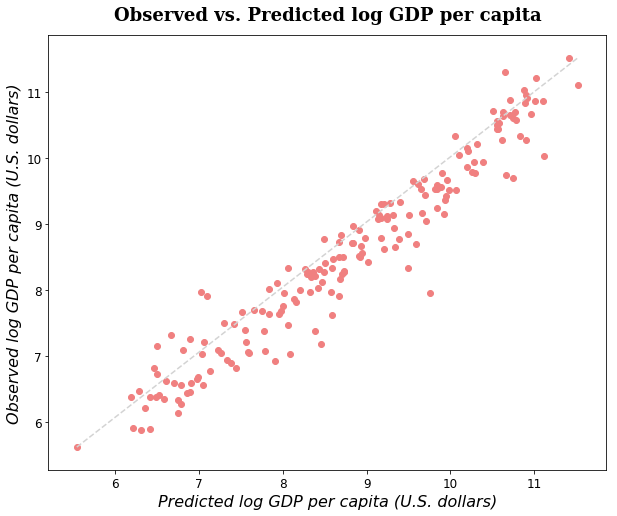

In [80]:
#Scatterplot of observed vs. predicted log GDP for X_test2
#Generally good fit but slight tendency to under-predict
plt.figure(figsize = (10,8))
plt.plot(np.linspace(fit2.predict(X_test2).min(), fit2.predict(X_test2).max()), 
         np.linspace(y_test.min(), y_test.max()), color = 'lightgrey', linestyle = '--')
plt.scatter(fit2.predict(X_test2), y_test, color = 'lightcoral')
plt.title("Observed vs. Predicted log GDP per capita", fontsize = 18, 
          fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel("Predicted log GDP per capita (U.S. dollars)", fontsize = 16, style = 'italic')
plt.ylabel("Observed log GDP per capita (U.S. dollars)", fontsize = 16, style = 'italic')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig('Obs_vs_Pred.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

In [107]:
# find country corresponding to largest residual
test.Country[np.abs(y_test['log_gdp'] - fit2.predict(X_test2)) ==\
             np.max(np.abs(y_test['log_gdp'] - fit2.predict(X_test2)))]

329    Libya
Name: Country, dtype: object

In [109]:
# residual of Libya (corresponds to about $6.14 offset from actual GDP per capita of Libya in 2015)
(y_test['log_gdp'] - fit2.predict(X_test2))[329]

-1.814108358087922

In [81]:
#Try removing 2 insignificant predictors from most recent model (at alpha = 0.05)
X_train4 = X_train2.drop(columns = ['log_pop', 'log_edu_prim'])
X_test4 = X_test2.drop(columns = ['log_pop', 'log_edu_prim'])

#No improvement on test data
lr_Train_Test(X_train4, X_test4, y_train, y_test)

Train R2:  0.9520939904022591
Test R2:  0.9003452615073542
Train Adj. R2:  0.9501611830986038
Test Adj. R2:  0.8919909720528808
Train RMSE:  0.33811204055312016
Test RMSE:  0.4470196774638034
Train MAE:  0.2631103348549687
Test MAE:  0.3384790998124433
Train AIC:  -757.0896412302836
Test AIC:  -265.0755697562972
Train BIC:  -702.6066222647228
Test BIC:  -220.2194761372221


In [82]:
#Try removing highly collinear predictor (correlated with sqrt_gva_ag)
X_train5 = X_train2.drop(columns = ['sqrt_gva_indst'])
X_test5 = X_test2.drop(columns = ['sqrt_gva_indst'])

#Loss of predictive performance, but do coefficients change?
lr_Train_Test(X_train5, X_test5, y_train, y_test)

Train R2:  0.9479824881715563
Test R2:  0.8906106873981366
Train Adj. R2:  0.9457273937281266
Test Adj. R2:  0.8807261109582092
Train RMSE:  0.3523225377413883
Test RMSE:  0.46834416149841285
Train MAE:  0.27634011603767916
Test MAE:  0.3631337343075049
Train AIC:  -725.2827531112234
Test AIC:  -246.1128790465492
Train BIC:  -666.9080899338369
Test BIC:  -198.0527787403973


In [83]:
#Yes- gva_servc, log_pop, and life_exp now insignificant
fit3 = sm.OLS(y_train, X_train5).fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_gdp   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     420.4
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          1.20e-211
Time:                        23:33:40   Log-Likelihood:                -136.01
No. Observations:                 362   AIC:                             304.0
Df Residuals:                     346   BIC:                             366.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.7130      0.650     11.866      0.000       6.434       8.991
gva_servc            -0.0033      0.002     -1.590      0.113      -0.007       0.001
labor_part           -0.0071      0.002     -3.357      0.001      -0.011      -0.003
food_prod             0.0032      0.001      2.230      0.026       0.000       0.006
life_exp              0.0059      0.005      1.170      0.243      -0.004       0.016
log_pop_density      -0.0751      0.016     -4.571      0.000      -0.107      -0.043
log_pop               0.0022      0.013      0.171      0.865      -0.023       0.027
log_energy_supp       0.1649      0.040      4.107      0.000       0.086       0.244
sqrt_internet         0.1609      0.018      9.137      0.000       0.126       0.196
log_edu_prim          0.0825      0.044      1.869      0.062      -0.004       0.169
sqrt_gva_ag          -0.3026      0.023    -13.431      0.000      -0.347      -0.258
sqrt_unemp           -0.0711      0.024     -2.907      0.004      -0.119      -0.023
log_tourism           0.1142      0.019      5.936      0.000       0.076       0.152
log_mort_child       -0.2919      0.062     -4.675      0.000      -0.415      -0.169
log_num_child         0.3357      0.083      4.069      0.000       0.173       0.498
log_ghg_emissions     0.1443      0.040      3.576      0.000       0.065       0.224
==============================================================================
Omnibus:                        1.063   Durbin-Watson:                   1.224
Prob(Omnibus):                  0.588   Jarque-Bera (JB):                0.824
Skew:                           0.055   Prob(JB):                        0.662
Kurtosis:                       3.206   Cond. No.                     5.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [84]:
#Still seeing significant multicollinearity with log_mort_child
vif2 = [{X_train5.columns[i]: variance_inflation_factor(np.array(X_train5), i)} for i in range(X_train5.shape[1])]
vif2

[{'Intercept': 1177.7539910739065},
 {'gva_servc': 2.5310954154539513},
 {'labor_part': 1.467170017914621},
 {'food_prod': 1.2926360162585282},
 {'life_exp': 6.210528725267562},
 {'log_pop_density': 1.435191265563372},
 {'log_pop': 1.7098660249964301},
 {'log_energy_supp': 6.302368277793516},
 {'sqrt_internet': 5.974281903630506},
 {'log_edu_prim': 1.8107681782492993},
 {'sqrt_gva_ag': 4.118296193725074},
 {'sqrt_unemp': 1.576419055115348},
 {'log_tourism': 4.9199368064210995},
 {'log_mort_child': 12.227239041857818},
 {'log_num_child': 4.836634896524206},
 {'log_ghg_emissions': 4.923858061174187}]

In [85]:
#Remove log_mort_child and log_pop
X_train6 = X_train5.drop(columns = ['log_mort_child', 'log_pop'])
X_test6 = X_test5.drop(columns = ['log_mort_child', 'log_pop'])

#Now gva_servc and log_edu_prim highly insignificant
fit4 = sm.OLS(y_train, X_train6).fit()
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_gdp   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     457.1
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          1.11e-209
Time:                        23:33:40   Log-Likelihood:                -147.18
No. Observations:                 362   AIC:                             322.4
Df Residuals:                     348   BIC:                             376.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.9414      0.538     11.050      0.000       4.884       6.999
gva_servc            -0.0014      0.002     -0.671      0.503      -0.005       0.003
labor_part           -0.0061      0.002     -2.820      0.005      -0.010      -0.002
food_prod             0.0022      0.001      1.489      0.137      -0.001       0.005
life_exp              0.0175      0.005      3.861      0.000       0.009       0.026
log_pop_density      -0.0727      0.017     -4.322      0.000      -0.106      -0.040
log_energy_supp       0.1886      0.041      4.614      0.000       0.108       0.269
sqrt_internet         0.1998      0.016     12.574      0.000       0.169       0.231
log_edu_prim          0.0525      0.045      1.170      0.243      -0.036       0.141
sqrt_gva_ag          -0.3067      0.023    -13.287      0.000      -0.352      -0.261
sqrt_unemp           -0.0859      0.025     -3.451      0.001      -0.135      -0.037
log_tourism           0.1181      0.017      7.077      0.000       0.085       0.151
log_num_child         0.2660      0.083      3.204      0.001       0.103       0.429
log_ghg_emissions     0.1526      0.041      3.686      0.000       0.071       0.234
==============================================================================
Omnibus:                        0.139   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.933   Jarque-Bera (JB):                0.039
Skew:                           0.012   Prob(JB):                        0.981
Kurtosis:                       3.045   Cond. No.                     4.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
#Test metrics have substantially worsened compared to X_train2 model
lr_Train_Test(X_train6, X_test6, y_train, y_test)

Train R2:  0.9446719561751875
Test R2:  0.875658540580535
Train Adj. R2:  0.9426051039633411
Test Adj. R2:  0.8660368800302193
Train RMSE:  0.3633609865169491
Test RMSE:  0.49932768291716945
Train MAE:  0.28440116795746745
Test MAE:  0.40345779565223755
Train AIC:  -706.9475436059488
Test AIC:  -226.7953499188676
Train BIC:  -656.3561688522137
Test BIC:  -185.14326298686927


In [87]:
#But no more concerning multicollinearity
vif3 = [{X_train6.columns[i]: variance_inflation_factor(np.array(X_train6), i)} for i in range(X_train6.shape[1])]
vif3

[{'Intercept': 761.9856224226152},
 {'gva_servc': 2.4219731357635825},
 {'labor_part': 1.4524015772072505},
 {'food_prod': 1.2416038702790064},
 {'life_exp': 4.7267254167831565},
 {'log_pop_density': 1.4237823548572988},
 {'log_energy_supp': 6.170981265251026},
 {'sqrt_internet': 4.596835035122273},
 {'log_edu_prim': 1.7703445780277478},
 {'sqrt_gva_ag': 4.088140969643103},
 {'sqrt_unemp': 1.5438200545053986},
 {'log_tourism': 3.500121249664903},
 {'log_num_child': 4.631456156150823},
 {'log_ghg_emissions': 4.90230176129218}]

In [88]:
X_train6.iloc[:,1:].corr()

,gva_servc,labor_part,food_prod,life_exp,log_pop_density,log_energy_supp,sqrt_internet,log_edu_prim,sqrt_gva_ag,sqrt_unemp,log_tourism,log_num_child,log_ghg_emissions
gva_servc,1.000,-0.142,-0.294,0.526,0.305,0.311,0.577,-0.127,-0.483,0.218,0.622,-0.499,0.234
labor_part,-0.142,1.000,0.194,-0.300,-0.067,-0.119,-0.158,0.262,0.218,-0.372,-0.162,0.226,-0.108
food_prod,-0.294,0.194,1.000,-0.240,-0.140,-0.236,-0.180,0.199,0.271,-0.190,-0.274,0.303,-0.179
life_exp,0.526,-0.300,-0.240,1.000,0.249,0.689,0.786,-0.425,-0.678,0.015,0.711,-0.803,0.597
log_pop_density,0.305,-0.067,-0.140,0.249,1.000,0.009,0.172,-0.044,-0.121,-0.135,0.187,-0.218,-0.128
log_energy_supp,0.311,-0.119,-0.236,0.689,0.009,1.000,0.769,-0.485,-0.782,0.026,0.663,-0.733,0.848
sqrt_internet,0.577,-0.158,-0.180,0.786,0.172,0.769,1.000,-0.404,-0.734,0.107,0.738,-0.745,0.663
log_edu_prim,-0.127,0.262,0.199,-0.425,-0.044,-0.485,-0.404,1.000,0.391,-0.064,-0.247,0.582,-0.455
sqrt_gva_ag,-0.483,0.218,0.271,-0.678,-0.121,-0.782,-0.734,0.391,1.000,-0.215,-0.714,0.659,-0.762
sqrt_unemp,0.218,-0.372,-0.190,0.015,-0.135,0.026,0.107,-0.064,-0.215,1.000,0.130,-0.129,0.073


In [89]:
#Try removing gva_servc and log_edu_prim
X_train7 = X_train6.drop(columns = ['gva_servc', 'log_edu_prim'])
X_test7 = X_test6.drop(columns = ['gva_servc', 'log_edu_prim'])

#Coefficients seem to have stabilized - remaining predictors significant
fit5 = sm.OLS(y_train, X_train7).fit()
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_gdp   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     540.5
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          4.79e-212
Time:                        23:33:40   Log-Likelihood:                -148.07
No. Observations:                 362   AIC:                             320.1
Df Residuals:                     350   BIC:                             366.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.9754      0.510     11.724      0.000       4.973       6.978
labor_part           -0.0057      0.002     -2.698      0.007      -0.010      -0.002
food_prod             0.0024      0.001      1.675      0.095      -0.000       0.005
life_exp              0.0180      0.005      3.967      0.000       0.009       0.027
log_pop_density      -0.0733      0.017     -4.369      0.000      -0.106      -0.040
log_energy_supp       0.1932      0.040      4.864      0.000       0.115       0.271
sqrt_internet         0.1963      0.015     12.894      0.000       0.166       0.226
sqrt_gva_ag          -0.3043      0.023    -13.400      0.000      -0.349      -0.260
sqrt_unemp           -0.0853      0.025     -3.459      0.001      -0.134      -0.037
log_tourism           0.1179      0.015      7.745      0.000       0.088       0.148
log_num_child         0.3099      0.076      4.087      0.000       0.161       0.459
log_ghg_emissions     0.1513      0.040      3.784      0.000       0.073       0.230
==============================================================================
Omnibus:                        0.104   Durbin-Watson:                   1.208
Prob(Omnibus):                  0.949   Jarque-Bera (JB):                0.027
Skew:                          -0.015   Prob(JB):                        0.987
Kurtosis:                       3.030   Cond. No.                     3.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
#Model performs about the same as X_train6
lr_Train_Test(X_train7, X_test7, y_train, y_test)

Train R2:  0.9444010785495539
Test R2:  0.8750133505151044
Train Adj. R2:  0.942653683875397
Test Adj. R2:  0.8669259790778465
Train RMSE:  0.36424938034389304
Test RMSE:  0.500621476759015
Train MAE:  0.2847716144337676
Test MAE:  0.40386582390515563
Train AIC:  -709.1795714064754
Test AIC:  -229.8534195883675
Train BIC:  -666.3714850763919
Test BIC:  -194.60934603052277


In [180]:
# Conduct random forest regression analysis - start by using grid search to select optimal hyperparameters
RF = RandomForestRegressor(n_jobs = -1, n_estimators = 100, random_state = 436, criterion = 'mse')
param_grid = dict(min_samples_leaf = [1, 5, 10, 25], 
                  max_features = [5, 10, None], 
                  bootstrap = [True, False]
                 )

RF_grid = GridSearchCV(RF, param_grid, scoring = None, n_jobs = -1, cv = 5, iid = False)
RF_grid.fit(X_train.iloc[:, 1:], y_train['log_gdp'])

print(RF_grid.best_score_)
print(RF_grid.best_params_)

0.9365767772986722
{'bootstrap': False, 'max_features': 5, 'min_samples_leaf': 1}


In [203]:
# fit RF model with optimal parameters to whole training set (no scaling or feature selection needed)
RF = RandomForestRegressor(n_jobs = -1, 
                           n_estimators = 500, 
                           random_state = 436, 
                           criterion = 'mse', 
                           min_samples_leaf = 1, 
                           max_features = 5, 
                           bootstrap = False
                          )
RF.fit(X_train.iloc[:, 1:], y_train['log_gdp'])

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=436, verbose=0,
                      warm_start=False)

In [204]:
# evaluate on training and test sets - explains 96% of variance in test set and has typical deviation of $1.30!
print('Train R2: ', r2_score(y_train, RF.predict(X_train.iloc[:, 1:])))
print('Test R2: ', r2_score(y_test, RF.predict(X_test.iloc[:, 1:])))
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, RF.predict(X_train.iloc[:, 1:])))) 
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, RF.predict(X_test.iloc[:, 1:]))))

Train R2:  0.9999999999755029
Test R2:  0.9647075895343439
Train RMSE:  7.645788096837324e-06
Test RMSE:  0.26602247196888357


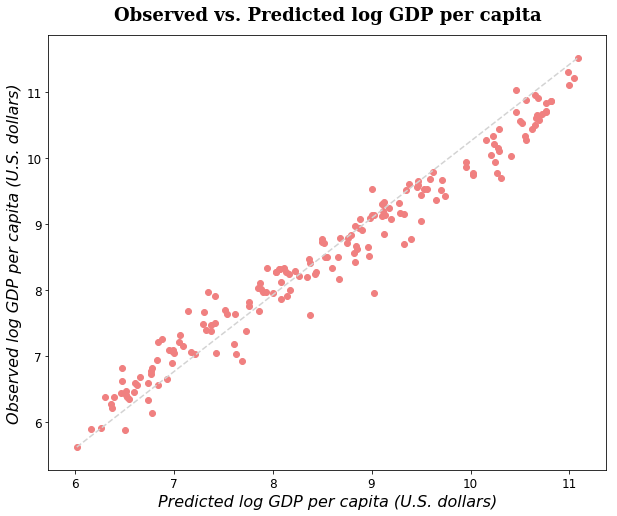

In [190]:
#Scatterplot of observed vs. predicted log GDP for RF model
plt.figure(figsize = (10,8))
plt.plot(np.linspace(RF.predict(X_test.iloc[:, 1:]).min(), RF.predict(X_test.iloc[:, 1:]).max()), 
         np.linspace(y_test.min(), y_test.max()), color = 'lightgrey', linestyle = '--')
plt.scatter(RF.predict(X_test.iloc[:, 1:]), y_test, color = 'lightcoral')
plt.title("Observed vs. Predicted log GDP per capita", fontsize = 18, 
          fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel("Predicted log GDP per capita (U.S. dollars)", fontsize = 16, style = 'italic')
plt.ylabel("Observed log GDP per capita (U.S. dollars)", fontsize = 16, style = 'italic')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig('Obs_vs_Pred_RF.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

In [191]:
# feature importances for RF model based on average variance reduction
dict(zip(X_train.iloc[:, 1:].columns, np.round(RF.feature_importances_, 4)))

{'exp_imp': 0.0185,
 'gva_servc': 0.0138,
 'labor_part': 0.0066,
 'food_prod': 0.0026,
 'life_exp': 0.071,
 'pop_gain': 0.0056,
 'urban': 0.0209,
 'log_pop_density': 0.0034,
 'log_pop': 0.005,
 'log_gender_ratio': 0.0045,
 'log_energy_prod': 0.014,
 'log_energy_supp': 0.1352,
 'sqrt_internet': 0.1273,
 'log_edu_prim': 0.0087,
 'sqrt_gva_ag': 0.187,
 'sqrt_gva_indst': 0.0061,
 'sqrt_unemp': 0.004,
 'log_tourism': 0.0728,
 'log_health': 0.0041,
 'sqrt_parliam_women': 0.0033,
 'log_cpi': 0.0037,
 'log_mort_child': 0.0909,
 'log_mort_mother': 0.061,
 'log_num_child': 0.0206,
 'log_pop_migrants': 0.019,
 'log_pop_unhcr': 0.0031,
 'log_ghg_emissions': 0.0875}

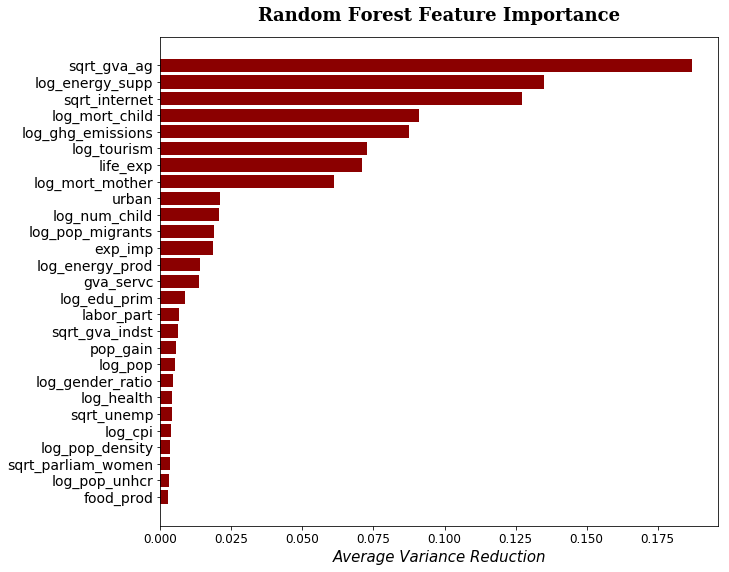

In [201]:
# barplot of RF feature importances
feature_imp_rf = pd.DataFrame({'features': X_train.iloc[:, 1:].columns, 
                               'importance': RF.feature_importances_})\
                                .sort_values('importance', ascending = True)

plt.figure(figsize = (10, 9))
plt.barh(feature_imp_rf['features'], feature_imp_rf['importance'], color = 'darkred')
plt.title("Random Forest Feature Importance", fontsize = 18, 
          fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel("Average Variance Reduction", fontsize = 15, style = 'italic')
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 14)

plt.savefig('RF_feature_importance.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

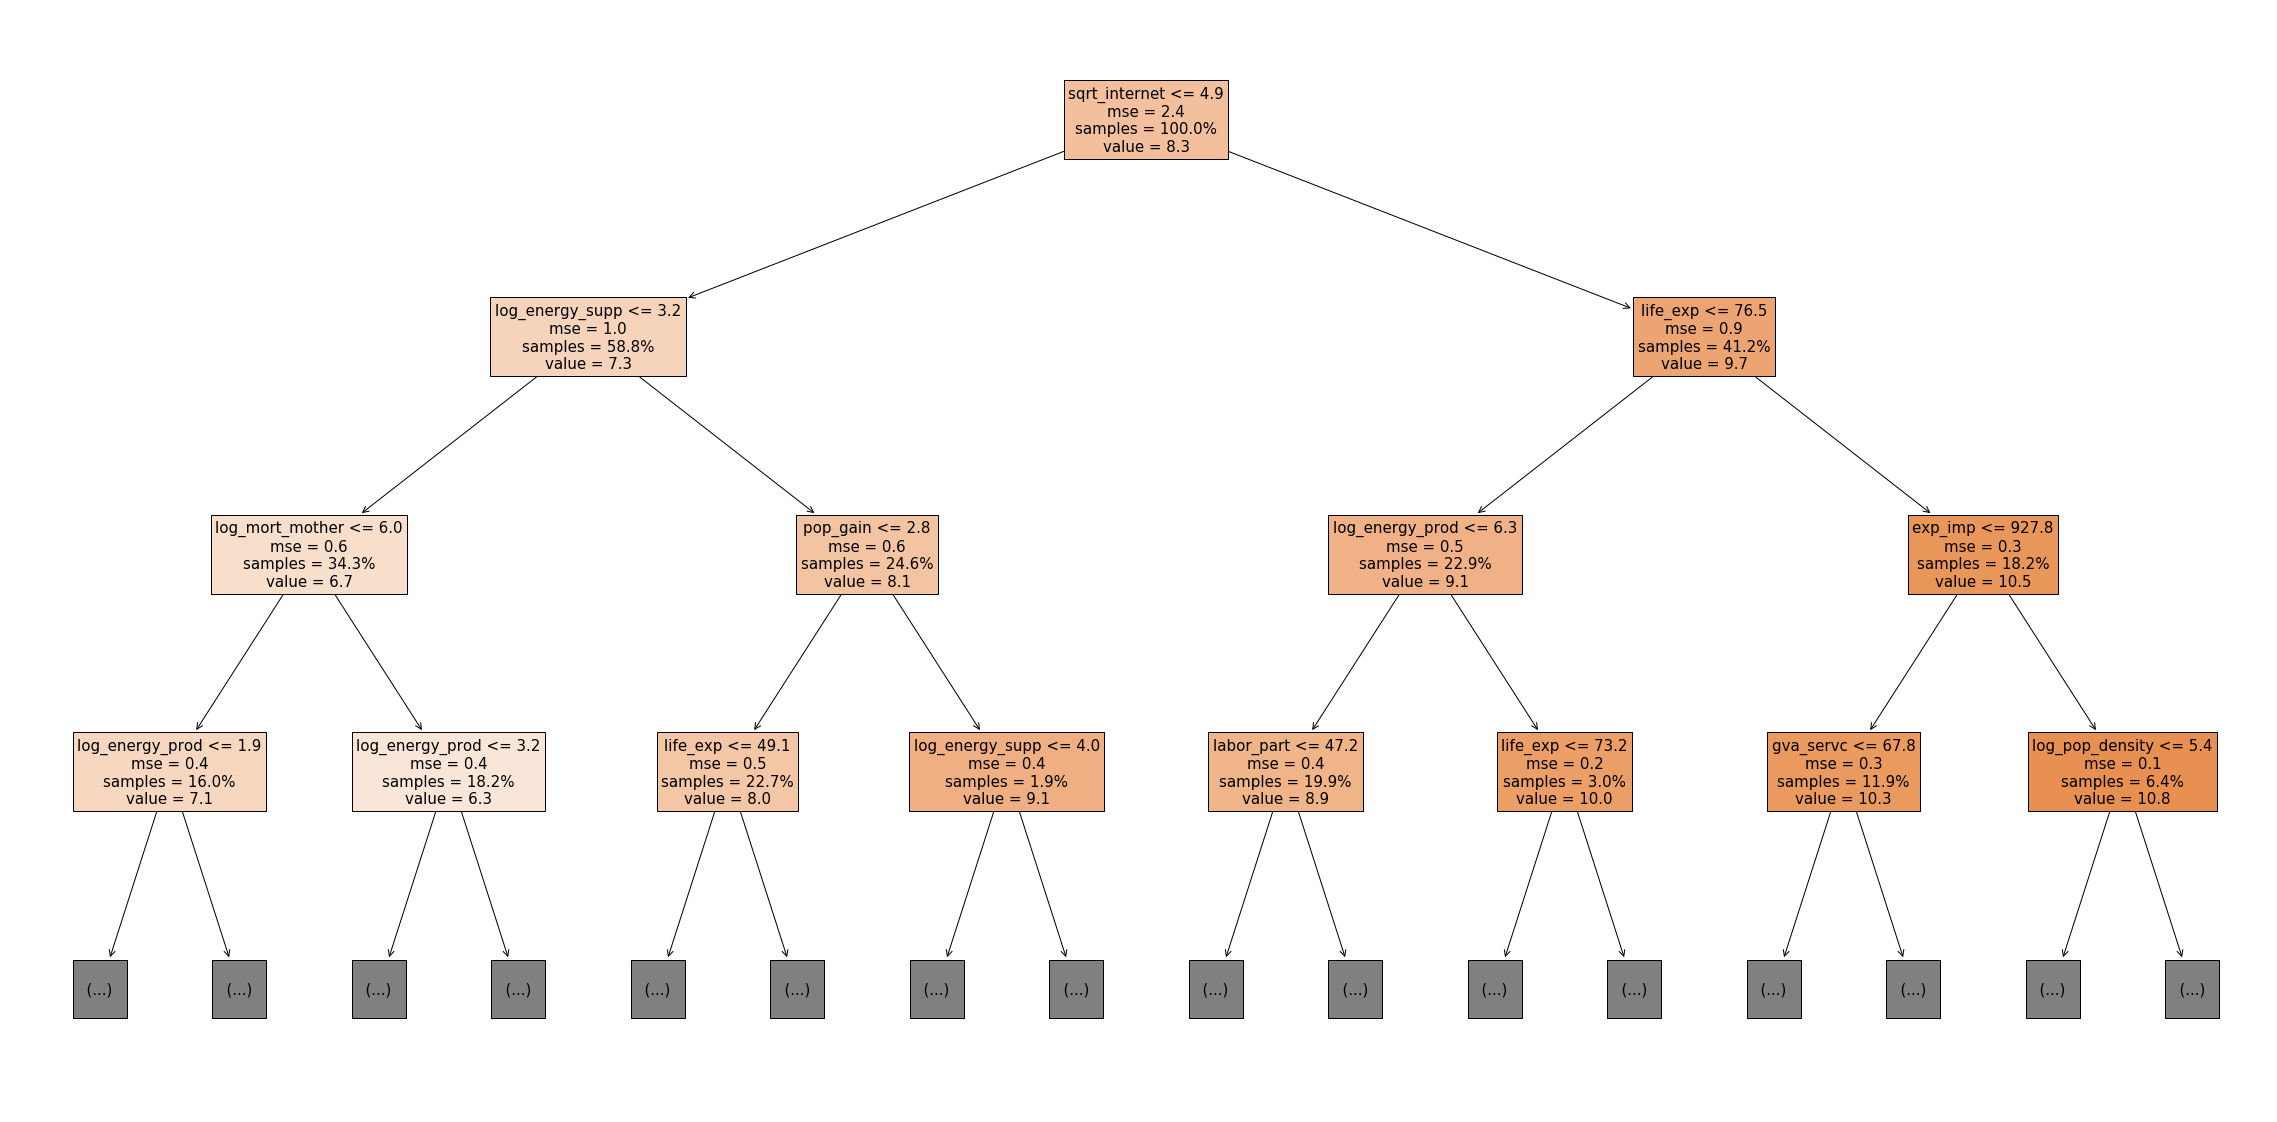

In [239]:
# plot first tree from RF showing feature split used, MSE, % of samples, and log GDP for each node
plt.figure(figsize = (40, 20))
plot_tree(RF.estimators_[0], feature_names = list(X_train.iloc[:, 1:].columns), max_depth = 3,
          filled = True, proportion = True, precision = 1, fontsize = 15, label = 'all')

plt.savefig('RF_tree.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()